In [1]:
import pickle

import em
from models import RBFInterpolatorModel, load_data


# Transformer 0.65um 


Octagonal transformer in TSMC 65 um. 1T + overlaped (balun)


In [2]:
#turn and freq independent @ 28GHz SRF > 38GHz
sub_spaces = [(1,1, "_balun"), (1,1, "")]

def ranges(df_train, df_test):
    df_test = df_test[df_test.Dinp > 30]
    df_test = df_test[df_test.Wp > 5]
    df_test = df_test[df_test.Dinp < 170 ]

    return  df_train, df_test


model_table = {}
for subsp in sub_spaces:
    print(f"Subspace: {subsp}")
    for f in range(201):

        freq, x_train, y_train, x_test, y_test, srf_data = load_data("../data/transf_65nm/", f, srf=38, nt=subsp, n_samples=1000, filter=ranges)
        
        if 'balun' in subsp[2]:
            m = RBFInterpolatorModel(degree=4)
            m.fit(x_train[:,[0,1]], y_train)
            pred = m.predict(x_test[:,[0,1]])
        else:
            m = RBFInterpolatorModel(degree=5)
            m.fit(x_train, y_train)
            pred = m.predict(x_test)

        mdl = {
                'freq_index': f,
                'freq': freq[0],
                'nt': subsp,
                'RBFmodel': m
        }
        model_table[(subsp, f)] = mdl

    srf_m = RBFInterpolatorModel(degree=3)
    if 'balun' in subsp[2]:
        srf_m.fit(srf_data[0][:, [0,1]], srf_data[1][:, [0]])
    else:
        srf_m.fit(srf_data[0], srf_data[1])
        
    srf_mdl = {
            'srf_limit': 38,
            'nt': subsp,
            'RBFmodel': srf_m
    }
    model_table[(subsp, 'srf')] = srf_mdl


Subspace: (1, 1, '_balun')
Subspace: (1, 1, '')


In [3]:
model_table['inputs'] = ['Dinp', 'Wp', 'Dins', 'Ws']
model_table['ouputs'] = em.COLUMNS_6P[1:]
model_table['device'] = 'transf'
model_table['model'] = 'transf'
model_table['ranges'] = {'dinp': (30, 190), 'wp': (4, 14), 'np': (1,1), 'dins': (30, 190), 'ws': (4, 14), 'ns': (1,1), 'freq': (0, 200)}
model_table['key'] = {'nt':sub_spaces, 'f':(0, 201)}

with open("../PASSIVES_RBF_TRANSF_BALUN_28G_SRF38.model",'wb') as outfile:
    pickle.dump(model_table, outfile)  

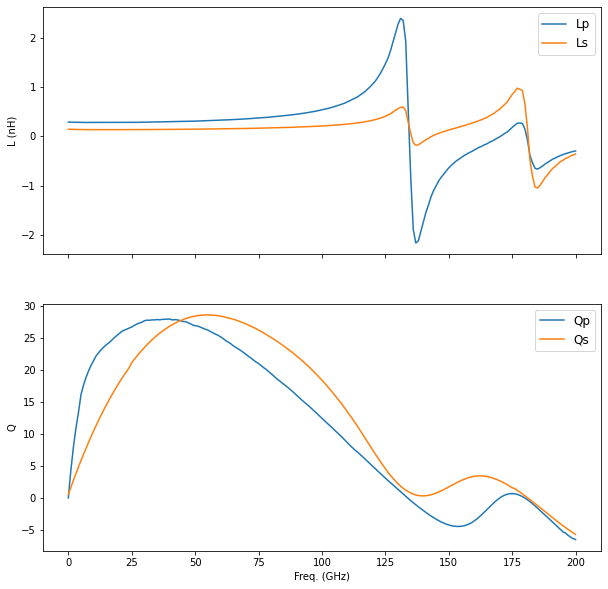

In [1]:
from models import PassivesModel

tranf_model = PassivesModel("../PASSIVES_RBF_TRANSF_BALUN_28G_SRF38.model")
resp, resp_arg = tranf_model.simulate(np=1, ns=1, dinp=117, wp=7, dins=40, ws=12) 
tranf_model.save(sri_fname="../test_out_in.sri", lq_fname= "../test_out_in.out")
tranf_model.plot()


###### Copyright (C) 2022 Instituto de Telecomunicações & IMSE CSIC